# Python spatial notebooks 3 : visualisation des données

Cyril Bernard, jan 2022

## Objectifs

Utiliser les fonctions plot des packages **geopandas** et **rasterio**, conjointement avec le package **matplotlib**, pour visualiser des données spatiales depuis Python.

## Sommaire

**Chargement des packages**

**Rappels sur matplotlib**

**Affichage des données vecteur**

- comment paramétrer l'apparence des symboles (polygones, lignes, points) ?
- comment créer une carte choroplèthe ?
- comment superposer plusieurs couches ?
- comment régler l'étendue ?
- comment modifier l'affichage des coordonnées ?

**Affichage des données raster**

- le module rasterio.plot
- comment changer la palette par défaut ?
- comment afficher une barre avec un gradient de couleur ?
- comment définir des classes de valeurs ?
- comment afficher des isolignes ?
- comment afficher une fenêtre d'un raster ? 
- remarques sur l'interopérabilité entre rasterio et matplotlib


## C'est parti !

### Chargement des packages

In [2]:
from os import listdir
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio

### Lecture des données (shapefiles et raster)


In [3]:
# chemin d'acces donnees : dossiers
d_data = "data"
d_ign = "IGN"
d_output = "output"
d_bdalti = join(d_data, d_ign, "BDALTIV2_MNT_25M_ASC_LAMB93_IGN69_D066")
d_bdtopo = join(d_data, d_ign, "BDT_3-0_SHP_LAMB93_D066-ED2021-03-15")
d_sncf = join(d_data, "SNCF")

# chemin d'acces données :fichiers
f_communes = join(d_bdtopo, "ADMINISTRATIF","COMMUNE.shp")
f_mnt = join(d_bdalti, "BDALTIV2_25M_FXX_0625_6175_MNT_LAMB93_IGN69.asc")
f_lignes_rfn = join(d_sncf, "formes-des-lignes-du-rfn", 
                    "formes-des-lignes-du-rfn.shp")
f_liste_gares = join(d_sncf, "liste-des-gares.csv")


In [47]:
# lecture du raster BDALTI
ds_mnt = rasterio.open(f_mnt)
# lire le shapefile BDTOPO COMMUNE.shp
gdf_communes = gpd.read_file(f_communes)
# lire le shapefile rfn
gdf_lignes_rfn = gpd.read_file(f_lignes_rfn)
# importer fichier csv avec spécification des colonnes
df_gares = pd.read_csv(
    f_liste_gares, 
    sep=';',
    usecols=[
        'CODE_UIC', 'LIBELLE',
        'COMMUNE', 'DEPARTEMEN', 
        'X_L93', 'Y_L93'
    ],
    dtype={
        'CODE_UIC': str, 'LIBELLE': str,
        'COMMUNE': str, 'DEPARTEMEN': str, 
        'X_L93': float, 'Y_L93': float,
        'X_WGS84': float, 'Y_WGS84': float
    }
)
# importer gares Pyrenees Orientale en tant que GeoDataFrame, CRS=2154
df_gares_66 = df_gares.query("DEPARTEMEN=='PYRENEES-ORIENTALES'")
gdf_gares = gpd.GeoDataFrame(
    df_gares_66, geometry=gpd.points_from_xy(
        df_gares_66.X_L93, df_gares_66.Y_L93, crs="EPSG:2154"))
gdf_gares.head()

CODE_UIC                           LIBELLE                   COMMUNE  \
4    87784512                          Le Soler                  LE SOLER   
10   87784736                             Nyers                      NYER   
249  87784686     Villefranche-Vernet-les-Bains  VILLEFRANCHE-DE-CONFLENT   
516  87784769  Fontpédrouse-St-Thomas-les-Bains              FONTPÉDROUSE   
518  87784496                  Espira-de-l'Agly          ESPIRA-DE-L'AGLY   

              DEPARTEMEN        X_L93         Y_L93  \
4    PYRENEES-ORIENTALES  682569.1484  6.175407e+06   
10   PYRENEES-ORIENTALES  639377.8490  6.160491e+06   
249  PYRENEES-ORIENTALES  648223.8313  6.165955e+06   
516  PYRENEES-ORIENTALES  633225.5654  6.157442e+06   
518  PYRENEES-ORIENTALES  686345.7490  6.185877e+06   

                           geometry  
4    POINT (682569.148 6175407.081)  
10   POINT (639377.849 6160490.633)  
249  POINT (648223.831 6165955.311)  
516  POINT (633225.565 6157442.038)  
518  POINT (686345.749 6185876.556)

## Rappel sur matplotlib : `figure` et `axes`

Une `figure` est une sorte de conteneur, qui peut rassembler 1 ou plusieurs "sous graphiques" (`axes`), et qui peut être enregistré comme 1 image.

Un `axes` = un graphique, avec des axes (`axis`), des graduations sur les axes (`ticks`), des symboles tracés sur l'espace du graphique ...

Ne pas confondre le terme `axes` (= un graphique, ou l'espace du graphique) avec `axis` (=les axes, abscisse et ordonnée par exemple si on est en 2D). 



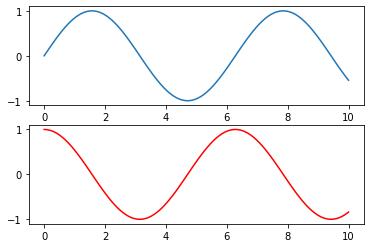

In [5]:
# nb de 0 à 100 à afficher
x = np.linspace(0, 10, 100)

# exemple : 1 figure avec 2 axes
# disposés en 2 lignes 1 colonnes
fig, ax = plt.subplots(2,1)

# graphiques 1 et 2
ax[0].plot(x, np.sin(x))
ax[1].plot(x, np.cos(x), color='red');

Si on veut afficher les 2 courbes sur le même graphique, on peut réutiliser le même `axes`.

In [6]:
# 1 seul graphique
# la taille de la figure est exprimée en pouces
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x, np.sin(x))
ax.plot(x, np.cos(x), color='red');

Selon la même logique, on peut afficher sur un même `axes` plusieurs couches SIG (raster, vecteur) : **l'objet `axes` sera notre espace géographique**.

Les méthodes les plus fréquemment utilisées pour représenter des données sur un `axes` sont les suivantes :

* `plot` : pour tracer des lignes
* `scatter` : pour tracer des points
* `text` : pour afficher du texte
* `imshow` : pour afficher une image (ou matrice)
* `hist` : pour afficher un histogramme

Les fonctions disponibles dans **geopandas** et **rasterio** pour afficher des données vectorielles et raster reposent sur ces fonctions de base de **matplotlib**.


## Affichage de données vecteur

### Comment paramétrer l'affichage des données vectorielles ?

On a vu précédemment comment afficher un shapefile. La méthode `plot` de geopandas repose sur celle du même nom dans matplotlib.

Documentation pour la fonction : <https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html>

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
gdf_communes.plot(ax=ax)


<AxesSubplot:>

#### Symbole unique

Les paramètres pour régler l'apparence des polygones et des lignes sont les suivants : 

- alpha = transparence
- color ou facecolor = couleur remplissage (polygone, point)
- edgecolor = couleur contour (polygone, point)
- linewidth or lw = largeur contour (polygone) ou ligne (ligne)
- markersize = taille symbole ponctuel, basée sur une colonne

Voir 
- GeoDataFrame.plot : <https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html>
- axes.plot : <https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.plot.html?highlight=plot#matplotlib.axes.Axes.plot>
- liste des couleurs : <https://matplotlib.org/stable/gallery/color/named_colors.html>
- liste des markers (symboles ponctuels) : <https://matplotlib.org/stable/api/markers_api.html>



<AxesSubplot:>

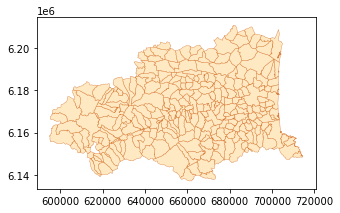

In [8]:
# exemple : polygone
fig, ax = plt.subplots(figsize=(5,5))
gdf_communes.plot(ax=ax, color = 'moccasin', edgecolor='chocolate', lw=0.4, alpha=0.8)


<AxesSubplot:>

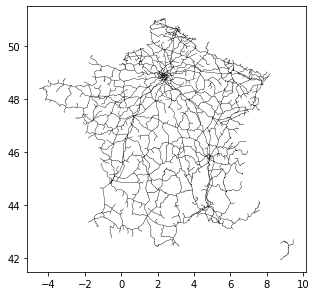

In [9]:
# exemple : ligne
fig, ax = plt.subplots(figsize=(5,5))
gdf_lignes_rfn.plot(ax=ax, color = 'black', lw=0.4)


In [10]:
# exemple : points
fig, ax = plt.subplots(figsize=(5,5))
gdf_gares.plot(ax=ax, marker='s', facecolor='lightgrey', edgecolor='midnightblue', alpha=0.4)


<AxesSubplot:>

#### Cartes choroplèthe

Faire varier la couleur des entités selon un attribut : c'est possible en indiquant la colonne contenant la variable à représenter, avec le paramètre **column**.


In [11]:
# exemple : densité
# calculer le nb d'hab / km2 dans une nouvelle colonne
gdf_communes['nbhab_km2'] = gdf_communes['POPULATION'] / (gdf_communes.area / 1000000)
fig, ax = plt.subplots(figsize=(8,4))
gdf_communes.plot(ax=ax, column = 'nbhab_km2', lw=0.4, legend=True)


<AxesSubplot:>

<AxesSubplot:>

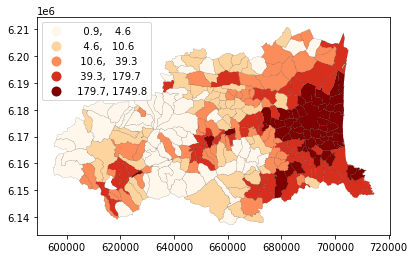

In [12]:
# exemple : densité
# calculer le nb d'hab / km2 dans une nouvelle colonne
gdf_communes['nbhab_km2'] = gdf_communes['POPULATION'] / (gdf_communes.area / 1000000)
fig, ax = plt.subplots(figsize=(8,4))
gdf_communes.plot(
    ax=ax, column='nbhab_km2', cmap='OrRd', edgecolor='black', scheme='quantiles', 
    lw=0.1, 
    legend=True, legend_kwds={"fmt": "{:.1f}", "loc": 'upper left'}
)


### Comment superposer plusieurs couches ?

Rappel : pour superposer plusieurs couches, il faut qu'elles soient dans le même SCR (dans l'exemple suivant, Lambert 93). Il faut spécifier l'`axes` dans lequel les couches sont affichées. C'est l'étendue maximale qui est prise en compte pour la carte.


<AxesSubplot:>

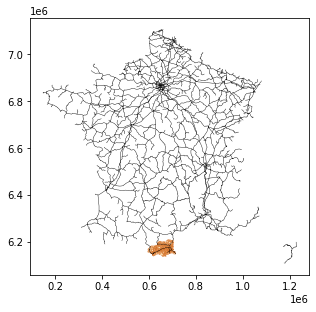

In [13]:
# convertir lignes_rfn (wgs 84) en lambert 93
gdf_lignes_l93 = gdf_lignes_rfn.to_crs("EPSG:2154")
# afficher couches
fig, ax = plt.subplots(figsize=(5,5))
gdf_communes.plot(ax=ax, color = 'moccasin', edgecolor='chocolate', lw=0.4, alpha=0.8)
gdf_lignes_l93.plot(ax=ax, color = 'black', lw=0.4)

### Comment régler l'étendue ?

Pour zoomer sur une étendue, il faut utiliser les méthodes `set_xlim` et `set_ylim`.

**Remarque** : pour obtenir les limites d'1 geodataframe, on utilise la méthode `total_bounds`. Pour obtenir les limites d'1 raster, la méthode `bounds`.

In [14]:
# comment obtenir les limites d'1 geodataframe ?
print("limites shapefile communes: ", gdf_communes.total_bounds)
xmin, ymin, xmax, ymax = gdf_communes.total_bounds
# comment obtenir les limites d'1 raster ?
print("limites raster: ", ds_mnt.bounds)
left, bottom, right, top = ds_mnt.bounds


limites shapefile communes:  [ 594789.  6137101.2  714655.  6210745.7]
limites raster:  BoundingBox(left=624987.5, bottom=6150012.5, right=649987.5, top=6175012.5)


<AxesSubplot:>

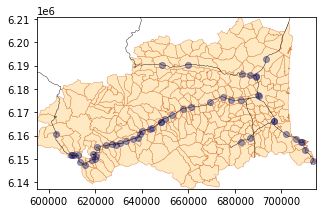

In [15]:
# coordonnées lambert 93 de la couche COMMUNE ?

fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
gdf_communes.plot(ax=ax, color = "moccasin", edgecolor="chocolate", lw=0.4, alpha=0.8)
gdf_lignes_l93.plot(ax=ax, color = 'black', lw=0.4)
gdf_gares.plot(ax=ax, marker='o', facecolor='midnightblue', alpha=0.4)


In [16]:
# afficher 2 axes : détails et vue d'ensemble

### Comment modifier les graduations ?

Comment modifier les graduations de manière à n'afficher que **le chiffre des milliers** ? 

Il faut modifier les propriétés des axes (`axis`) X et Y, en leur passant une [fonction de formatage](https://matplotlib.org/stable/gallery/ticks/tick-formatters.html#tick-formatters). Cette fonction prend 2 arguments : _x_, la valeur du tick et _pos_ la position du tick. Autre possibilité : une chaîne avec le formatage de _x_, la valeur du tick.


<AxesSubplot:>

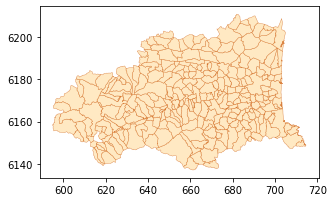

In [23]:
# fonction lambda formatter : diviser par 1000 et convertir en chaîne
fig, ax = plt.subplots(figsize=(5,5))
# une fonction lambda pour le formatage
ax.xaxis.set_major_formatter(lambda x, pos: str(int(x / 1000)))
ax.yaxis.set_major_formatter(lambda x, pos: str(int(x / 1000)))
gdf_communes.plot(ax=ax, color = "moccasin", edgecolor="chocolate", lw=0.4, alpha=0.8)


#### Masquer les graduations

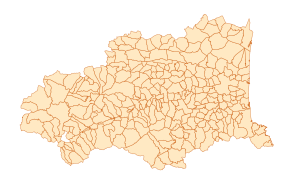

In [24]:
fig, ax = plt.subplots(figsize=(5,5))
gdf_communes.plot(ax=ax, color = "moccasin", edgecolor="chocolate", lw=0.4, alpha=0.8)
ax.set_axis_off()

## Affichage de données raster

### Le module rasterio.plot

La fonction `show` du module **rasterio.plot** reprend les mêmes paramètres et fonctionnalités que `imshow` dans matplotlib.

Voir <https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html>

Par défaut, les valeurs du raster sont représentées avec la palette _viridis_.

<AxesSubplot:>

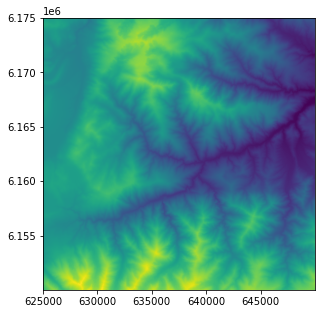

In [25]:
# afficher le relief de la dalle 
from rasterio.plot import show
fig, ax = plt.subplots(figsize=(5,5))
show(ds_mnt, ax=ax)


### Comment changer la palette par défaut ?

Avec le paramètre `cmap`.

<AxesSubplot:>

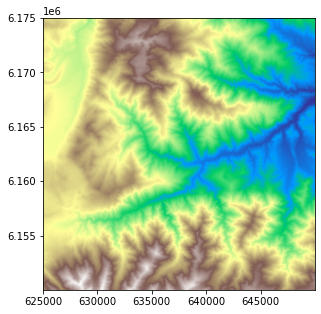

In [26]:
# avec palette = "terrain"
from rasterio.plot import show
fig, ax = plt.subplots(figsize=(5,5))
show(ds_mnt, ax=ax, cmap='terrain')


### Comment afficher une barre avec un gradient de couleurs ?

La fonction `show` du module **rasterio.plot**  est toutefois limitée. Par exemple, si on souhaite afficher une légendes pour les valeurs du raster, il n'est hélas pas possible de récupérer la table couleurs / valeurs pour la fonction `colorbar`.

C'est pourquoi on est obligé de recourir à la fonction `imshow` de matplotlib.

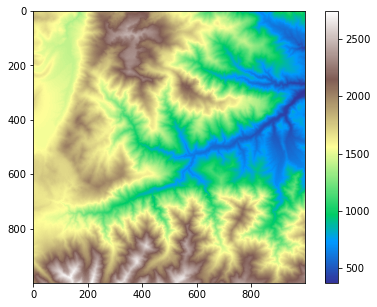

In [27]:
# afficher le relief de la dalle + légende
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,5))
img = ax.imshow(ds_mnt.read(1), cmap='terrain')
fig.colorbar(img, ax=ax)


### Comment afficher les classes de valeurs ?

Dans l'exemple précédent, les couleurs sont interpolées suivant l'altitude d'après la palette de couleurs. 

Comment faire si on souhaite "discrétiser" les couleurs, en définissant des classes avec des bornes inférieures et supérieures, et en appliquant une couleur à chaque classe ?

Le module **rasterio.plot** ne permet pas cela. Il faut faire directement appel à la fonction dédiée dans matplotlib : `contourf` (voir <https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.contourf.html>).


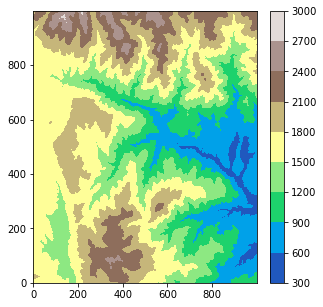

In [28]:
# imshow avec une colorbar
from rasterio.plot import show
fig, ax = plt.subplots(figsize=(5,5))
img = ax.contourf(ds_mnt.read(1), cmap='terrain')
fig.colorbar(img, ax=ax)


Pour **définir les bornes** des classes, plusieurs solutions s'offrent à nous :

- définir les bornes min et max pour l'ensemble des valeurs avec `vmin` et `vmax`, puis le nombre de classes
- définir explicitement toutes les bornes avec `level`

Quant aux couleurs associées aux classes, il est possible de les spécifier manuellement avec `colors` (exemple ci-dessous avec les couleurs issues de <https://en.wikipedia.org/wiki/Wikipedia:WikiProject_Maps/Conventions/Topographic_maps>).


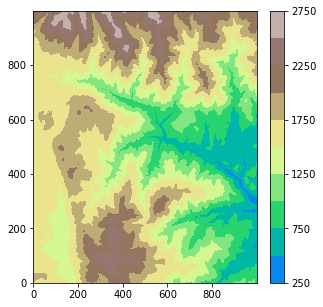

In [29]:
# les classes d'intervalles agaux sont automatiquement calculées entre 0 et 3000 
# de maniere a ce que "ca tombe juste", et les classes en dehors du min-max pas affichees
from rasterio.plot import show
fig, ax = plt.subplots(figsize=(5,5))
img = ax.contourf(ds_mnt.read(1), levels=10, vmin=0, vmax=3000, cmap='terrain')
fig.colorbar(img, ax=ax)


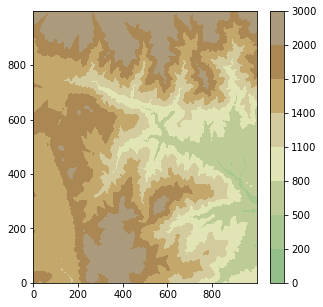

In [30]:
# classes spécifiées manuellement avec levels
# couleurs issues de wikipedia
from rasterio.plot import show
fig, ax = plt.subplots(figsize=(5,5))
img = ax.contourf(
    ds_mnt.read(1), 
    levels=[0, 200, 500, 800, 1100, 1400, 1700, 2000, 3000], 
    colors=['#94BF8B', '#A8C68F', '#BDCC96', '#E1E4B5', '#D3CA9D', '#C3A76B', '#AA8753', '#AC9A7C'])
fig.colorbar(img, ax=ax)


### Comment afficher des courbes de niveau ?

Générer des isolignes d'après un raster est possible dans matplotlib, avec la fonction `contour` qui est très similaire à la fonction `contourf` vue précédemment.

A noter que le module rasterio appelle cette fonction `contour`, lorsqu'on utilise la fonction `show` avec **contour=True**.

<AxesSubplot:>

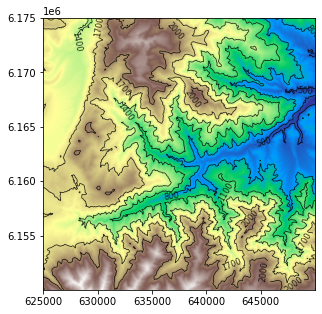

In [31]:
# rasterio avec palette = "terrain" + affichage des isolignes
from rasterio.plot import show
fig, ax = plt.subplots(figsize=(5,5))
show(ds_mnt, ax=ax, cmap='terrain')
show(
    ds_mnt, ax=ax, contour=True, 
    colors='black',
    levels= [0,200, 500, 800, 1100, 1400, 1700, 2000, 3000],
    linewidths=0.8
)


### Comment afficher une fenêtre de raster ?

In [36]:
from rasterio.windows import Window
win = Window(0, 0, 350, 250)
values_win = ds_mnt.read(window=win)
# afficher la partie découpée avec rasterio.plot.show ...
# il faut calculer la fonction de transformation de la partie découpée
win_transform = rasterio.windows.transform(win, ds_mnt.transform)
show(values_win, transform=win_transform, cmap='terrain')


<AxesSubplot:>

### Remarques sur l'interopérabilité entre rasterio et matplotlib

Quand on utilise la méthode `read` de rasterio sans préciser l'index de la bande, nous obtenons un tableau numpy avec 3 axes : 

- l'axe 0 : bandes
- l'axe 1 : lignes
- l'axe 2 : colonnes

In [44]:
values_win.shape

(1, 250, 350)

Alors que d'habitude, les images lues avec le package **Pillow** et affichées avec `imshow` sont organisées dans cet ordre : 

- axe 0 : lignes
- axe 1 : colonnes
- axe 2 : bandes

C'est pourquoi, si on voulait afficher ce tableau numpy de 1 x 250 x 350 valeurs avec la fonction imshow de matplotlib, il faudrait transposer les données pour obtenir un tableau de 250 x 350 x 1. C'est possible avec `numpy.transpose` ou avec `rasterio.plot.reshape_as_image` .

Cf. <https://rasterio.readthedocs.io/en/latest/topics/image_processing.html>

In [45]:
from rasterio.plot import reshape_as_image
values_im = reshape_as_image(values_win)
values_im.shape

(250, 350, 1)

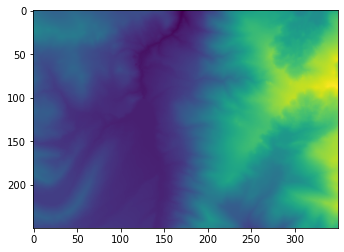

In [46]:
# matplotlib imshow
plt.imshow(values_im)

In [41]:
# et à l'inverse, repasser d'un raster à une image
from rasterio.plot import reshape_as_raster
values_raster = reshape_as_raster(values_im)
values_raster.shape

(1, 250, 350)